<a href="https://colab.research.google.com/github/jeric250/Data-Science-Projects/blob/main/Classification_Gradient_Boosting_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>Gradient Boosting Decision Trees (XGBoost) on DonorsChoose Dataset</h3>

The dataset contains classroom project proposals in need of funding received by [DonorsChoose](https://www.donorschoose.org/), a NGO based in the US. 

The goal is to build a model to predict whether a project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. The NGO can use this information to identify projects most likely to need further review before approval.

Extreme Gradient Boosting (XGBoost) is an efficient implementation of the stochastic gradient boosting machine learning algorithm. It is an ensemble of decision trees where new trees fix errors of those trees that are already part of the model.

The dataset contains a mix of categorical, numerical and text data. For text data, the TF-IDF vectorizer is used to convert text into vectors. Hyperparameter tuning is performed to obtain the best hyperparameters for XGBoost, and model performance is subsequently evaluated. 

This is partly inspired by the course work from the Applied Roots's [Applied Machine Learning course](https://www.appliedaicourse.com/course/11/Applied-Machine-learning-course).

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from scipy.sparse import hstack
import xgboost as xgb

import re

import pickle
from tqdm import tqdm
import os

In [ ]:
!pip install --upgrade category_encoders

     |████████████████████████████████| 80 kB 3.0 MB/s 


In [ ]:
# import category_encoders as ce
from category_encoders import TargetEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data/preprocessed_data.csv', nrows=50000) # obtain 80,000 data points

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   school_state                                  50000 non-null  object 
 1   teacher_prefix                                50000 non-null  object 
 2   project_grade_category                        50000 non-null  object 
 3   teacher_number_of_previously_posted_projects  50000 non-null  int64  
 4   project_is_approved                           50000 non-null  int64  
 5   clean_categories                              50000 non-null  object 
 6   clean_subcategories                           50000 non-null  object 
 7   essay                                         50000 non-null  object 
 8   price                                         50000 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 3.4+ MB


In [ ]:
print("No. of Data Points:", data.shape[0])
print("No. of Features:", data.shape[1])
print("\nUnique values:\n", data.nunique())

No. of Data Points: 50000
No. of Features: 9

Unique values:
 school_state                                       51
teacher_prefix                                      5
project_grade_category                              4
teacher_number_of_previously_posted_projects      274
project_is_approved                                 2
clean_categories                                   45
clean_subcategories                               357
essay                                           49765
price                                           30399
dtype: int64


In [ ]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,compound,sentiment
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.9867,positive
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.9897,positive
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00,0.9860,positive
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04,0.9524,positive
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74,0.9873,positive


In [ ]:
data.groupby('project_is_approved').size() # imbalanced data (19%:81%)

project_is_approved
0     8007
1    41993
dtype: int64

<h4>1. Calculate sentiment scores on the essay feature</h4>
VADER’s SentimentIntensityAnalyzer() takes in a string and returns a dictionary of scores in each of four categories: negative, neutral, positive, and compound (normalized total scores between -1 and +1).

In [ ]:
# calculate sentiment scores on the essay feature
# ref:https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664 
# https://stackoverflow.com/questions/61608057/output-vader-sentiment-scores-in-columns-based-on-dataframe-rows-of-tweets
# https://gist.github.com/BenjaminFraser/fc4dd29549a75c93336822060d012ec8

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
positive_threshold = 0.05
negative_threshold = -0.05

# for each essay in dataset, compute sentiment scores, extract compound score from dictionary, and save compound score to new column entitled 'compound'
data['compound'] = [analyzer.polarity_scores(essay)['compound'] for essay in data['essay']]
# categorize essay as positive if compound score is at least 0.05, negative if score is -0.05 and under, else neutral
data['sentiment'] = data['compound'].apply(lambda x: 'positive' if x>=positive_threshold else ('negative' if x<=negative_threshold else 'neutral'))

data[['essay','compound','sentiment']].head() # check output

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,essay,compound,sentiment
0,i fortunate enough use fairy tale stem kits cl...,0.9867,positive
1,imagine 8 9 years old you third grade classroo...,0.9897,positive
2,having class 24 students comes diverse learner...,0.9860,positive
3,i recently read article giving students choice...,0.9524,positive
4,my students crave challenge eat obstacles brea...,0.9873,positive


In [ ]:
data.groupby('sentiment').size() # most essays are positive sentiment

sentiment
negative      361
neutral        31
positive    49608
dtype: int64

In [ ]:
df = data.copy()
df.drop('compound', axis=1, inplace=True) # drop compound scores column and only use sentiment column for model
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   school_state                                  50000 non-null  object 
 1   teacher_prefix                                50000 non-null  object 
 2   project_grade_category                        50000 non-null  object 
 3   teacher_number_of_previously_posted_projects  50000 non-null  int64  
 4   project_is_approved                           50000 non-null  int64  
 5   clean_categories                              50000 non-null  object 
 6   clean_subcategories                           50000 non-null  object 
 7   essay                                         50000 non-null  object 
 8   price                                         50000 non-null  float64
 9   sentiment                                     50000 non-null 

<h4>2. Split dataset into train and test set</h4>

In [ ]:
y = df['project_is_approved']
X = df.drop(['project_is_approved'], axis=1)
X.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,sentiment
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,positive
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,positive
2,ca,mrs,grades_prek_2,10,literacy_language,literacy,having class 24 students comes diverse learner...,329.00,positive
3,ga,mrs,grades_prek_2,2,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04,positive
4,wa,mrs,grades_3_5,2,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74,positive


In [ ]:
# train test split (no validation set as intend to do Randomized Search CV)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(33500, 9) (33500,)
(16500, 9) (16500,)


<h4>3. Perform TF-IDF Vectorization, Categorical Encoding, Numerical Scaling</h4>

In [ ]:
# identify categorical features for encoding
categorical_col = list(X.select_dtypes(include=['object','category']).drop(['essay'], axis=1).columns)
categorical_col

['school_state',
 'teacher_prefix',
 'project_grade_category',
 'clean_categories',
 'clean_subcategories',
 'sentiment']

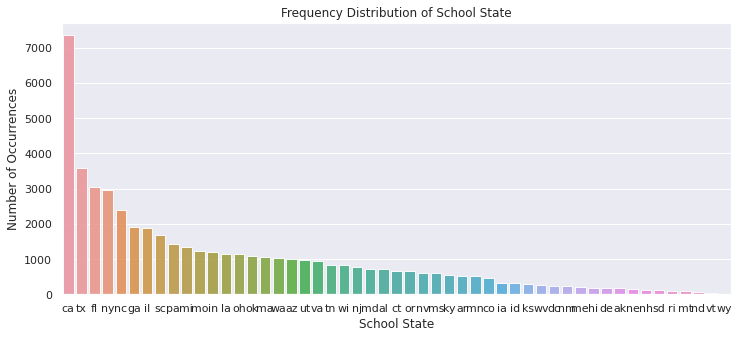

In [ ]:
# categorical features like school state, project category have high cardinality
# as an example, refer to distribution plot for school state below

plt.figure(figsize=(12,5))
school_count = X['school_state'].value_counts()
sns.set(style="darkgrid")
sns.barplot(school_count.index, school_count.values, alpha=0.9)
plt.title('Frequency Distribution of School State')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('School State', fontsize=12)
plt.show()

>* Implementing one hot encoding on high cardinality categorical features will 
signficantly increase the dimensionality of training data. This in turn especially affects the performance of decision trees, since there is a need to evaluate each feature for information gain. 
* The computational complexity to train a decision tree is O(d*n(log n)), where d is the no. of dimensions and n is amount of samples. Thus, as d increases significantly, the complexity increases signficantly.
* In addition, one hot encoding on high cardinality features introduces sparse features and can negatively affect the performance of decision tree.
* To address this, target encoding is used, where each category in a feature is replaced with the mean target value for samples having that category, while keeping the dimensionality of data the same as the unencoded data.
* However, target encoding is prone to target leakage (as the probability of target variable is used to encode the features) and overfitting. In addition, the dataset is imbalanced, with 85% of projects belonging to class 1 (approved). Thus, a stronger smoothing is used as a form of regularization, and to place higher emphasis on overall average vs categorical average.

References: 
1. [sklearn Decision Tree Page](https://scikit-learn.org/stable/modules/tree.html#complexity)
2. [SO: Categorical Data for Decision Tree](https://stackoverflow.com/questions/38108832/passing-categorical-data-to-sklearn-decision-tree)
3. [SO: Decision Tree Runtime](https://stackoverflow.com/questions/34212610/why-is-the-runtime-to-construct-a-decision-tree-mnlogn)
4. [sklearn Target Encoder](https://contrib.scikit-learn.org/category_encoders/targetencoder.html)
5. [Target Encoding article](https://maxhalford.github.io/blog/target-encoding/)

In [ ]:
# use target encoder to encode categorical features
enc = TargetEncoder(smoothing = 3.0) # use stronger smoothing than default
enc.fit(X_train[categorical_col].values, y_train) # fit on training data

# use the fitted encoder to encode categorical features
X_train_te = enc.transform(X_train[categorical_col].values)
X_test_te = enc.transform(X_test[categorical_col].values)

# use the fitted encoder to encode categorical features of train and test data
print(X_train_te.shape, y_train.shape)
print(X_test_te.shape, y_test.shape)

(33500, 6) (33500,)
(16500, 6) (16500,)


In [ ]:
# check for null (NaN) elements in array (as there are cases where target encoder adds NaN to dataset) - refer to note below
np.isnan(np.sum(X_train_te)) # get sum of array first as if any elements in array is NaN, then sum is NaN (ref:https://stackoverflow.com/questions/6736590/fast-check-for-nan-in-numpy)

0    False
1    False
2    False
3    False
4    False
5    False
dtype: bool

> There appears to be cases where target encoder introduces NaN values to dataset (which originally does not have any NaN values), where the cause and solution is unclear. For the above case, there is no NaN values introduced after applying target encoding. References on the issue: 
1. [Kaggle Q&A section](https://www.kaggle.com/questions-and-answers/204970)
2. [SO: Target Encoder](https://stackoverflow.com/questions/68261917/why-is-target-encoder-encoding-some-values-as-nan)
3. [Target Encoder Issue](https://github.com/scikit-learn-contrib/category_encoders/issues/340)

In [ ]:
# identify numerical features
numerical_col = list(X.select_dtypes(include=['int','float']).columns)
numerical_col

['teacher_number_of_previously_posted_projects', 'price']

In [ ]:
# generally, decision trees do not require normalization/scaling as it is an information/tree based algorithm (unlike distance based like linear models)
# ref: https://datascience.stackexchange.com/questions/5277/do-you-have-to-normalize-data-when-building-decision-trees-using-r
# https://datascience.stackexchange.com/questions/60950/is-it-necessary-to-normalize-data-for-xgboost
# https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package

# save numerical features dataset
X_train_num = X_train[numerical_col]
X_test_num = X_test[numerical_col]

print(X_train_num.shape, y_train.shape)
print(X_test_num.shape, y_test.shape)

(33500, 2) (33500,)
(16500, 2) (16500,)


In [ ]:
# perform TF-IDF vectorization of text data (essay column)
tfidf_vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,4), max_features=6000)
tfidf_vectorizer.fit(X_train['essay'].values) # fit only on train data

# use the fitted TfidfVectorizer to convert the text to vector
X_train_essay_tfidf = tfidf_vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf = tfidf_vectorizer.transform(X_test['essay'].values)

print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

(33500, 6000) (33500,)
(16500, 6000) (16500,)


In [ ]:
# merge matrices for TF-IDF
X_train_tfidf = hstack((X_train_essay_tfidf, X_train_te, X_train_num)).tocsr()
X_test_tfidf = hstack((X_test_essay_tfidf, X_test_te, X_test_num)).tocsr()

print("Final data matrix (TF-IDF)")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

Final data matrix (TF-IDF)
(33500, 6008) (33500,)
(16500, 6008) (16500,)


<h4>4. Perform Hyperparameter Tuning</h4>

In [ ]:
# TF-IDF hyperparameter tuning for 2 hyperparameters (time taken: 33 mins)
# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
# https://stackoverflow.com/questions/69786993/tuning-xgboost-hyperparameters-with-randomizedsearchcv
# https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn/notebook
# https://www.datacamp.com/tutorial/xgboost-in-python

xgb_ht = xgb.XGBClassifier()
parameters = {'max_depth': [3, 6, 9],
              'n_estimators': [100, 150, 200]}

clf = RandomizedSearchCV(xgb_ht, parameters, cv=3, scoring='roc_auc', n_iter=6, return_train_score=True, random_state=42, n_jobs=-1) 
clf.fit(X_train_tfidf, y_train)

print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)

Best cross-validation score: 0.72
Best parameters:  {'n_estimators': 200, 'max_depth': 3}


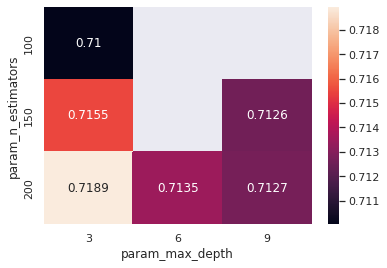

In [25]:
# plot heatmap to visualise results of hyperparameter tuning
# ref: https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
# https://stackoverflow.com/questions/56302647/how-to-plot-a-heatmap-and-find-best-hyperparameter-for-decision-tree-after-grids

results = pd.DataFrame.from_dict(clf.cv_results_) #cv_results_ returns dict of metrics/details on Random Search CV

max_scores = results.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

<h4>5. Compute Performance Metrics of Model on Test Set</h4>

**Use class weightage parameter**

>As the dataset is imbalanced (with 81% of data points belonging to positive class), let's use XGBoost's class weightage hyperparameter (scale_pos_weight) to control the balance of positive and negative weights. For scale_pos_weight, a typical value to consider: sum(negative instances) / sum(positive instances). 

References:
1. [XGBoost parameter documentation](https://xgboost.readthedocs.io/en/latest/parameter.html)
2. [Github: Sample code](https://github.com/dmlc/xgboost/blob/master/demo/kaggle-higgs/higgs-cv.py)
3. [XGBoost for Imbalanced Classification](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/)

In [26]:
# define value for scale_pos_weight (typically not part of hyperparameter tuning)
ratio = np.sum(y_train==0)/np.sum(y_train==1)
ratio

0.19068775546472366

In [27]:
clf.best_params_

{'max_depth': 3, 'n_estimators': 200}

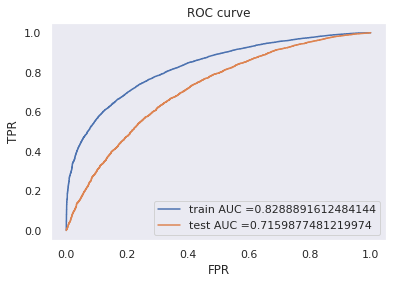

In [28]:
# compute and plot ROC (time taken: 7 mins)
best_depth_tfidf = clf.best_params_['max_depth']
best_n_estimators_tfidf = clf.best_params_['n_estimators']
clf = xgb.XGBClassifier(max_depth=best_depth_tfidf, n_estimators=best_n_estimators_tfidf, scale_pos_weight=ratio, random_state=42)
clf.fit(X_train_tfidf, y_train)

y_train_pred = clf.predict_proba(X_train_tfidf)[:,1] # include proba for positive class only
y_test_pred = clf.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred) 
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()

In [29]:
auc_tfidf = auc(test_fpr, test_tpr)
print('The AUC score on test data is {:.2f}'.format(auc_tfidf))

The AUC score on test data is 0.72


In [30]:
# define function to obtain best threshold for max(tpr*(1-fpr)) + predict class using best threshold

def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be max if fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr) is", max(tpr*(1-fpr)), "with threshold of", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

The maximum value of tpr*(1-fpr) is 0.561450416055859 with threshold of 0.489


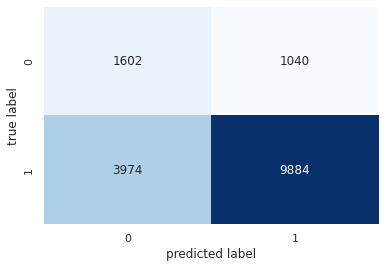

In [31]:
# plot confusion matrix of model performance on test data points
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm_test_tfidf = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

sns.heatmap(cm_test_tfidf, cmap='Blues', annot=True, fmt='g', cbar=False)
plt.xlabel('predicted label')
plt.ylabel('true label');

In [32]:
tn, fp, fn, tp = cm_test_tfidf.ravel()
recall = tp/(fn+tp)
precision = tp/(tp+fp)
print('The AUC score is {:.2f}'.format(auc_tfidf))
print('The TPR (sensitivity/recall) is {:.2f}, while the FNR is {:.2f}'.format(recall, fn/(fn+tp)))
print('The TNR (specificity) is {:.2f}, while the FPR is {:.2f}'.format(tn/(tn+fp), fp/(tn+fp)))
print('Precision is {:.2f}'.format(precision))
print('F1-score is {:.2f}'.format(2*(precision*recall)/(precision+recall)))

The AUC score is 0.72
The TPR (sensitivity/recall) is 0.71, while the FNR is 0.29
The TNR (specificity) is 0.61, while the FPR is 0.39
Precision is 0.90
F1-score is 0.80


>While the AUC score of 0.72 is greater than 0.5, it not particularly high. As the dataset is imbalanced in favour of the positive class, identifying true negatives is relatively important, lending more importance to specificity (which is modest at 0.61). Correspondingly, the false positive rate is not high at 0.39.

<h4>6. Analyze False Positives </h4>

> As specificity is important, let's analyze false positivies further to get a better understanding on how/why the model misclassified these data points.

In [34]:
# prepare list of features names for feature importance
features_tfidf = []
features_tfidf.extend(tfidf_vectorizer.get_feature_names())
features_tfidf.extend(enc.get_feature_names())
features_tfidf.append('teacher_number_of_previously_posted_projects')
features_tfidf.append('project_cost') # price feature

len(features_tfidf)

6008

In [46]:
# create df containing feature and its respective feature importance
# https://towardsdatascience.com/understanding-decision-trees-for-classification-python-9663d683c952
importances = pd.DataFrame({'feature':features_tfidf,'feat_importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('feat_importance',ascending=False)
importances.head(15) # obtain top 15 features

,feature,feat_importance
6007,project_cost,0.009
3113,materials,0.009
5842,wobble,0.008
3378,nannan,0.008
4725,stools,0.007
5143,supplies,0.006
5337,these materials,0.006
5599,use,0.006
2517,ipad,0.006
4248,rug,0.006


>Project_cost (price) appears to be the most important feature, along with the word text from the essay feature and no. of previously posted projects. Let's further analyze these 3 features.

In [36]:
# make predictions on test data using the trained model on best threshold
y_pred_class = np.array(predict_with_best_t(y_test_pred, best_t)) # output is a list so need to transform to array

# identify false positives where class is 1 in y_pred_class but the class is actually 0 in y_test, and obtain false positive data points from dataset
# ref: https://stackoverflow.com/questions/50094999/how-to-return-an-array-of-false-positives-from-a-confusion-matrix-in-scikit-lear
# https://stackoverflow.com/questions/51878608/how-to-view-the-rows-marked-as-false-positive-and-false-negative-from-confusion
false_positives = np.logical_and(y_test == 0, y_pred_class == 1)

X_test_fp = X_test[false_positives]
X_test_fp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040 entries, 22476 to 5388
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   school_state                                  1040 non-null   object 
 1   teacher_prefix                                1040 non-null   object 
 2   project_grade_category                        1040 non-null   object 
 3   teacher_number_of_previously_posted_projects  1040 non-null   int64  
 4   clean_categories                              1040 non-null   object 
 5   clean_subcategories                           1040 non-null   object 
 6   essay                                         1040 non-null   object 
 7   price                                         1040 non-null   float64
 8   sentiment                                     1040 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 81.2+ KB


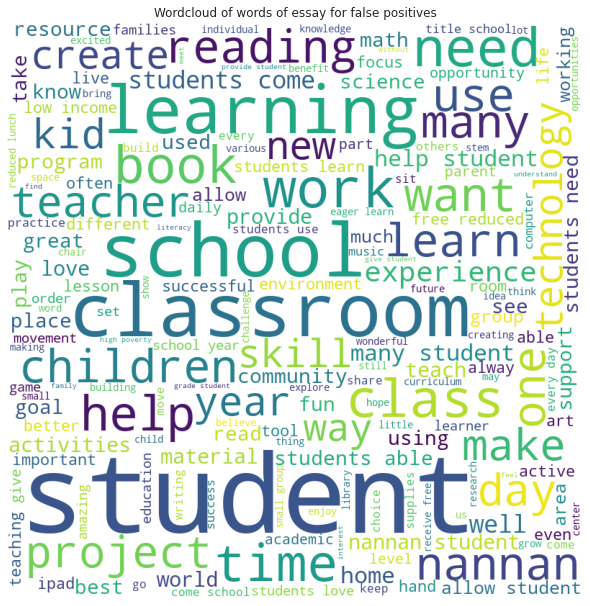

In [37]:
# create wordcloud of words from the essay feature of false positives
# ref: https://www.geeksforgeeks.org/generating-word-cloud-python/

from wordcloud import WordCloud, STOPWORDS
essay_words = ''
stopwords = set(STOPWORDS)
 
# iterate through each essay in essay feature
for essay in X_test_fp.essay:
    # change each value to string
    essay = str(essay)
 
    # split the value into tokens
    tokens = essay.split()
     
    # convert each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    essay_words += " ".join(tokens)+" " # save each word (token) as part of string
 
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(essay_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Wordcloud of words of essay for false positives')
 
plt.show()

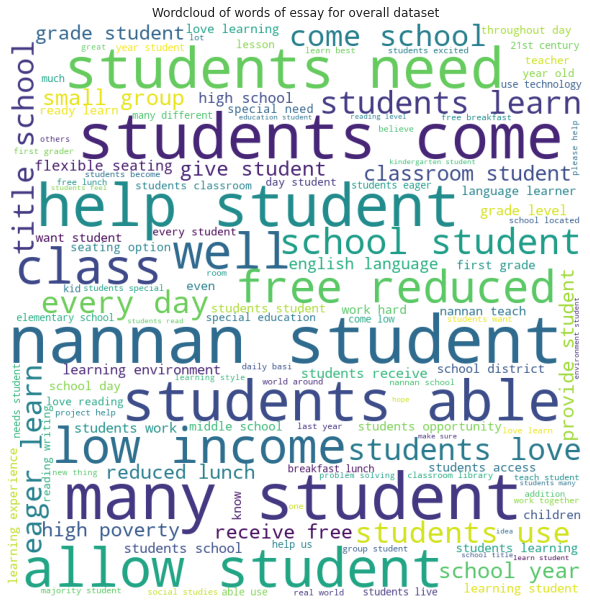

In [38]:
# create wordcloud of words from the essay feature of overall dataset
# ref: https://www.geeksforgeeks.org/generating-word-cloud-python/
essay_words = ''
stopwords = set(STOPWORDS)
 
# iterate through each essay in essay feature
for essay in df.essay:
    # change each value to string
    essay = str(essay)
 
    # split the value into tokens
    tokens = essay.split()
     
    # convert each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    essay_words += " ".join(tokens)+" " # save each word (token) as part of string
 
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(essay_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Wordcloud of words of essay for overall dataset')
 
plt.show()

>**Essay**: The most common words from essay of false positive points are student, classroom, school and learning. For overall dataset, the most common words are student (or some variation of it), learn and school. As there are similarities, this suggests that most project applications have essays that emphasized on students and learning, thus top common words from essay may not provide much info on whether a project is approved or not.

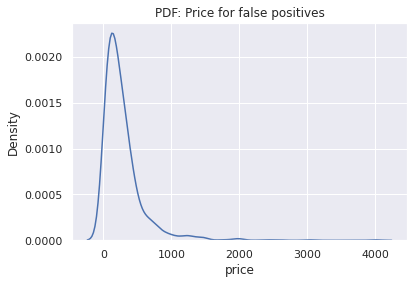

In [47]:
sns.distplot(X_test_fp['price'], hist=False)
plt.title('PDF: Price for false positives')
plt.show();

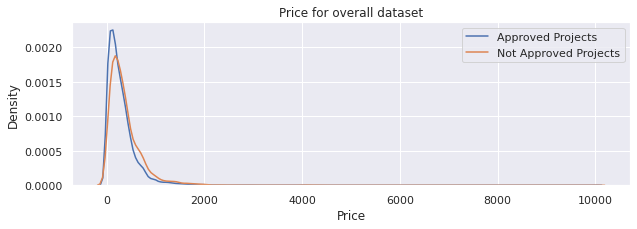

In [53]:
approved_price = df[df['project_is_approved']==1]['price'].values
rejected_price = df[df['project_is_approved']==0]['price'].values

plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Price for overall dataset')
plt.xlabel('Price')
plt.legend()
plt.show()

In [42]:
# compare percentile of project price between approved and rejected projects for overall dataset
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,10):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.69       |          2.55         |
|     10     |       33.54       |         76.888        |
|     20     |       79.934      |        127.426        |
|     30     |       120.2       |         179.0         |
|     40     |      166.214      |        230.964        |
|     50     |       215.95      |         286.97        |
|     60     |      279.102      |        354.088        |
|     70     |       349.0       |        430.662        |
|     80     |      441.456      |        566.258        |
|     90     |      623.468      |        762.846        |
|    100     |       9999.0      |         9999.0        |
+------------+-------------------+-----------------------+


>**Price**: The distribution of price for overall dataset is right skewed, where majority of projects are under 1000. The distribution of price for false positive points is right skewed, although not as much as overall dataset. From the overall dataset, approved projects tend to have lower prices at each percentile level compared to rejected projects. This suggests that since projects tagged as false positives have lower price, the model may have used this to misclassify the projects as approved.

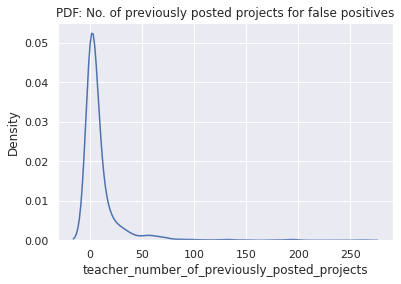

In [49]:
sns.distplot(X_test_fp['teacher_number_of_previously_posted_projects'], hist=False)
plt.title('PDF: No. of previously posted projects for false positives')
plt.show();

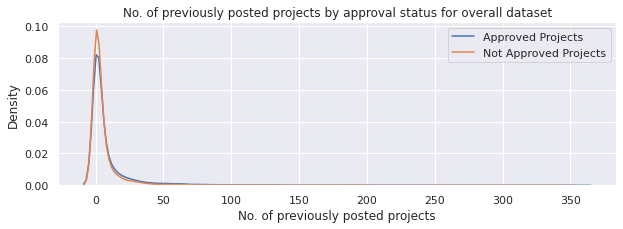

In [51]:
# plot pdf of teacher_number_of_previously_posted_projects for overall dataset
approved_ppp = df[df['project_is_approved']==1]['teacher_number_of_previously_posted_projects'].values
rejected_ppp = df[df['project_is_approved']==0]['teacher_number_of_previously_posted_projects'].values

plt.figure(figsize=(10,3))
sns.distplot(approved_ppp, hist=False, label="Approved Projects")
sns.distplot(rejected_ppp, hist=False, label="Not Approved Projects")
plt.title('No. of previously posted projects by approval status for overall dataset')
plt.xlabel('No. of previously posted projects')
plt.legend()
plt.show()

In [54]:
# compare percentile of projects previously submitted between approved and rejected projects for overall dataset
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,10):
    x.add_row([i,np.round(np.percentile(approved_ppp,i), 3), np.round(np.percentile(rejected_ppp,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.0        |          0.0          |
|     10     |        0.0        |          0.0          |
|     20     |        0.0        |          0.0          |
|     30     |        0.0        |          0.0          |
|     40     |        1.0        |          1.0          |
|     50     |        2.0        |          1.0          |
|     60     |        3.0        |          2.0          |
|     70     |        6.0        |          4.0          |
|     80     |        11.0       |          7.0          |
|     90     |        25.0       |          15.0         |
|    100     |       356.0       |         345.0         |
+------------+-------------------+-----------------------+


>**No. of previously posted projects**: While distribution of no. of previously posted projects of both overall dataset and false positive points is similarly right skewed, the distribution for false positive has a lower density peak at 0 projects. This indicates that for projects tagged as false positive, there are more teachers who had previously posted projects (at least 1). As 'experienced' teachers who had posted projects previously have slightly higher chance of approval, the model may have used this to misclassify the projects as approved.